* separate train | val | test sets
* I deleted images with original size > 48x48 to get rid of full body & multiple people images. That cost 1343 removed images (57756 kept)

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import tensorflow as tf
import os
from PIL import Image
import kaggle
from sklearn.model_selection import train_test_split
import keras_cv
from tensorflow import keras


ModuleNotFoundError: No module named 'resource'

In [ ]:
# DOWNLOAD THE DATASET
# Computer must have a unique kaggle.json file downloaded and have this path: "C:\Users\youruser\.kaggle\kaggle.json"

dataset_name = 'samithsachidanandan/human-face-emotions'
target_folder = 'human-face-emotions'

kaggle.api.dataset_download_files(dataset_name, path=target_folder, unzip=True)
print("Download complete!")

In [2]:
data_dir = './human-face-emotions/data'

In [ ]:
base_folder = data_dir

summary = {}   # to store removed / kept per class
total_removed = 0
total_kept = 0

for label in os.listdir(base_folder):
    class_path = os.path.join(base_folder, label)
    removed = 0
    kept = 0

    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)

        try:
            img = Image.open(img_path)
            w, h = img.size
            img.close()  # ← IMPORTANT: close file so Windows unlocks it

            if (w, h) != (48, 48):
                os.remove(img_path)
                removed += 1
            else:
                kept += 1

        except:
            # corrupted or unreadable → try closing + remove
            try:
                img.close()
            except:
                pass
            os.remove(img_path)
            removed += 1
      

    summary[label] = {"removed": removed, "kept": kept}
    total_removed += removed
    total_kept += kept

# Print class-by-class report
print("=== Removal Report by Class ===")
for label, stats in summary.items():
    print(f"{label}: removed {stats['removed']}, kept {stats['kept']}")

print("\n=== TOTAL ===")
print("Total removed:", total_removed)
print("Total kept:", total_kept)

In [3]:
full_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    label_mode="int",
    image_size=(48, 48),
    color_mode="grayscale",
    batch_size=None,      # return one (img, label) at a time
    shuffle=True,
    seed=42
)

class_names = full_ds.class_names
num_classes = len(class_names)

print("Classes:", class_names)

Found 57756 files belonging to 5 classes.
Classes: ['Angry', 'Fear', 'Happy', 'Sad', 'Suprise']


In [4]:
full_data = list(full_ds.as_numpy_iterator())

images = [x[0] for x in full_data]  # list of arrays
labels = [x[1] for x in full_data]  # list of ints

In [6]:
# First split: train vs temp (val+test)
x_train, x_temp, y_train, y_temp = train_test_split(
    images, labels,
    test_size=0.30,         # 30% → val+test
    random_state=42,
    stratify=labels         # keeps class proportions
)

# Second split: val vs test (each = 15%)
x_val, x_test, y_val, y_test = train_test_split(
    x_temp, y_temp,
    test_size=0.50,         # half of 30% = 15%
    random_state=42,
    stratify=y_temp
)

In [7]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
val_ds   = tf.data.Dataset.from_tensor_slices((x_val, y_val))
test_ds  = tf.data.Dataset.from_tensor_slices((x_test, y_test))

In [8]:
batch_size = 128

train_ds = train_ds.shuffle(10000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_ds   = val_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_ds  = test_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [14]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.05),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomTranslation(0.1, 0.1),
])

In [38]:
# early stopping to prevent overfitting
callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(48, 48, 1)),
    data_augmentation,

    tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(48, 48, 1)),
    tf.keras.layers.MaxPooling2D(),
    # 32: number of filters -> 32 different pattern detectors
    # (3×3) = kernel (=filter) size in pixels - like a (3×3) window
    # padding='same' : 48×48 input → 48×48 output
    # MaxPooling : reduces image size by taking the maximum value in each 3x3 window
    # e.g. pooling keeps the strongest signals
    

    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Flatten(),

    # --- Dense layers ---
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    #optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

c:\Users\sandralm\AppData\Local\miniconda3\envs\IDS\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)       │ (None, 48, 48, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 48, 48, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 24, 24, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 683,269 (2.61 MB)

 Trainable params: 683,269 (2.61 MB)

 Non-trainable params: 0 (0.00 B)

In [41]:
history_1 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=[callback]
)

Epoch 1/50
316/316 ━━━━━━━━━━━━━━━━━━━━ 22s 71ms/step - accuracy: 0.5177 - loss: 1.1751 - val_accuracy: 0.5448 - val_loss: 1.1168
Epoch 2/50
316/316 ━━━━━━━━━━━━━━━━━━━━ 23s 72ms/step - accuracy: 0.5326 - loss: 1.1585 - val_accuracy: 0.5436 - val_loss: 1.1406
Epoch 3/50
316/316 ━━━━━━━━━━━━━━━━━━━━ 23s 72ms/step - accuracy: 0.5400 - loss: 1.1329 - val_accuracy: 0.5816 - val_loss: 1.0130
Epoch 4/50
316/316 ━━━━━━━━━━━━━━━━━━━━ 25s 78ms/step - accuracy: 0.5536 - loss: 1.1118 - val_accuracy: 0.5866 - val_loss: 1.0388
Epoch 5/50
316/316 ━━━━━━━━━━━━━━━━━━━━ 25s 80ms/step - accuracy: 0.5566 - loss: 1.1008 - val_accuracy: 0.5999 - val_loss: 1.0053
Epoch 6/50
316/316 ━━━━━━━━━━━━━━━━━━━━ 27s 85ms/step - accuracy: 0.5595 - loss: 1.0865 - val_accuracy: 0.5776 - val_loss: 1.0451
Epoch 7/50
316/316 ━━━━━━━━━━━━━━━━━━━━ 23s 72ms/step - accuracy: 0.5675 - loss: 1.0719 - val_accuracy: 0.6103 - val_loss: 0.9709
Epoch 8/50
316/316 ━━━━━━━━━━━━━━━━━━━━ 21s 67ms/step - accuracy: 0.5754 - loss: 1.0561 - 

Above
* comaparing accuracy and val_accuracy + whether both are increasing or not help detect under/overfitting
* Loss holds more information. Loss is higher if the correct class in predicted but with low confidence

In [42]:
test_loss, test_acc = model.evaluate(test_ds)
print("Final Test Accuracy:", test_acc)

68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.6574 - loss: 0.8648
Final Test Accuracy: 0.6477377414703369


In [30]:
#model.save("cnn_p1.h5")
model.save('cnn_p2.keras')


In [15]:
import numpy as np
from sklearn.metrics import confusion_matrix

# Collect predictions
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images)
    preds = np.argmax(preds, axis=1)
    
    y_true.extend(labels.numpy())
    y_pred.extend(preds)

# Convert lists to arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

cm = confusion_matrix(y_true, y_pred)
cm

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
4/4 ━━━━━━━━

array([[1068,  127,   90,  164,   37],
       [ 151,  876,   65,  229,  136],
       [  70,   49, 2460,   80,   38],
       [ 191,  164,  115, 1321,   32],
       [  23,   59,   39,   17, 1063]])

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━

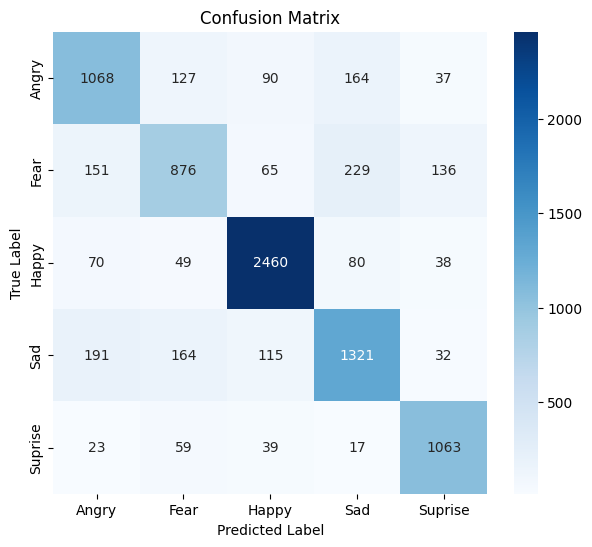

In [22]:
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images)
    preds = np.argmax(preds, axis=1)
    
    y_true.extend(labels.numpy())
    y_pred.extend(preds)

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Create confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot heatmap
plt.figure(figsize=(7, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [17]:
confusions = []

for i in range(len(class_names)):
    for j in range(len(class_names)):
        if i != j:  # skip diagonal
            confusions.append((cm[i][j], class_names[i], class_names[j]))

confusions_sorted = sorted(confusions, reverse=True)

print("Top confusion pairs:")
for count, true_label, pred_label in confusions_sorted[:10]:
    print(f"{true_label} → {pred_label}: {count}")


Top confusion pairs:
Fear → Sad: 229
Sad → Angry: 191
Sad → Fear: 164
Angry → Sad: 164
Fear → Angry: 151
Fear → Suprise: 136
Angry → Fear: 127
Sad → Happy: 115
Angry → Happy: 90
Happy → Sad: 80


In [18]:
per_class_acc = cm.diagonal() / cm.sum(axis=1)

for label, acc in zip(class_names, per_class_acc):
    print(f"{label}: {acc:.3f}")


Angry: 0.719
Fear: 0.601
Happy: 0.912
Sad: 0.725
Suprise: 0.885


In [19]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred, target_names=class_names))


              precision    recall  f1-score   support

       Angry       0.71      0.72      0.71      1486
        Fear       0.69      0.60      0.64      1457
       Happy       0.89      0.91      0.90      2697
         Sad       0.73      0.72      0.73      1823
     Suprise       0.81      0.89      0.85      1201

    accuracy                           0.78      8664
   macro avg       0.77      0.77      0.77      8664
weighted avg       0.78      0.78      0.78      8664



precision
* if precision=0.6 -> if model predicts x, it is correct 60% of the time
* shows how much you can trust the prediction

recall
* percent of instances, the model catches out of a class
* Low recall → the model misses many examples of that class

F1-score
* harmonic mean of precision and recall

Support
* number of samples of that class in the test set


## Default cnn

In [24]:
model_default_cnn = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(48, 48, 1)),
    data_augmentation,

    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

model_default_cnn.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model_default_cnn.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)       │ (None, 48, 48, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 46, 46, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 23, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 21, 21, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 355,589 (1.36 MB)

 Trainable params: 355,589 (1.36 MB)

 Non-trainable params: 0 (0.00 B)

In [25]:
history_2 = model_default_cnn.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15
)

Epoch 1/15
316/316 ━━━━━━━━━━━━━━━━━━━━ 22s 60ms/step - accuracy: 0.2979 - loss: 4.7466 - val_accuracy: 0.4340 - val_loss: 1.3593
Epoch 2/15
316/316 ━━━━━━━━━━━━━━━━━━━━ 18s 56ms/step - accuracy: 0.4109 - loss: 1.4072 - val_accuracy: 0.5039 - val_loss: 1.2124
Epoch 3/15
316/316 ━━━━━━━━━━━━━━━━━━━━ 18s 55ms/step - accuracy: 0.4620 - loss: 1.3084 - val_accuracy: 0.5227 - val_loss: 1.1727
Epoch 4/15
316/316 ━━━━━━━━━━━━━━━━━━━━ 18s 55ms/step - accuracy: 0.4930 - loss: 1.2383 - val_accuracy: 0.5437 - val_loss: 1.1349
Epoch 5/15
316/316 ━━━━━━━━━━━━━━━━━━━━ 18s 57ms/step - accuracy: 0.5209 - loss: 1.1854 - val_accuracy: 0.5481 - val_loss: 1.1329
Epoch 6/15
316/316 ━━━━━━━━━━━━━━━━━━━━ 18s 56ms/step - accuracy: 0.5340 - loss: 1.1513 - val_accuracy: 0.5677 - val_loss: 1.0930
Epoch 7/15
316/316 ━━━━━━━━━━━━━━━━━━━━ 18s 56ms/step - accuracy: 0.5519 - loss: 1.1126 - val_accuracy: 0.5915 - val_loss: 1.0272
Epoch 8/15
316/316 ━━━━━━━━━━━━━━━━━━━━ 18s 56ms/step - accuracy: 0.5576 - loss: 1.0953 - 

In [26]:
test_loss, test_acc = model_default_cnn.evaluate(test_ds)
print("Final Test Accuracy:", test_acc)

68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.6294 - loss: 0.9562
Final Test Accuracy: 0.6218836307525635


## Baseline CNN
- no data augmentation bc it truncated the accuracy

In [ ]:
model_og_CNN = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(48, 48, 1)),

    tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(48, 48, 1)),
    tf.keras.layers.MaxPooling2D(),
    # 32: number of filters -> 32 different pattern detectors
    # (3×3) = kernel (=filter) size in pixels - like a (3×3) window
    # padding='same' : 48×48 input → 48×48 output
    # MaxPooling : reduces image size by taking the maximum value in each 3x3 window
    # e.g. pooling keeps the strongest signals
    

    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Flatten(),

    # --- Dense layers ---
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

model_og_CNN.compile(
    #optimizer=tf.keras.optimizers.Adam(1e-4),
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model_og_CNN.summary()

c:\Users\sandralm\AppData\Local\miniconda3\envs\IDS\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 48, 48, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 24, 24, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 683,269 (2.61 MB)

 Trainable params: 683,269 (2.61 MB)

 Non-trainable params: 0 (0.00 B)

In [45]:
history_3 = model_og_CNN.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=[callback]
)

Epoch 1/50
316/316 ━━━━━━━━━━━━━━━━━━━━ 20s 64ms/step - accuracy: 0.5425 - loss: 1.0947 - val_accuracy: 0.5847 - val_loss: 1.0291
Epoch 2/50
316/316 ━━━━━━━━━━━━━━━━━━━━ 23s 73ms/step - accuracy: 0.5534 - loss: 1.0675 - val_accuracy: 0.5992 - val_loss: 0.9987
Epoch 3/50
316/316 ━━━━━━━━━━━━━━━━━━━━ 21s 66ms/step - accuracy: 0.5639 - loss: 1.0412 - val_accuracy: 0.6029 - val_loss: 0.9951
Epoch 4/50
316/316 ━━━━━━━━━━━━━━━━━━━━ 22s 70ms/step - accuracy: 0.5817 - loss: 1.0063 - val_accuracy: 0.6096 - val_loss: 0.9676
Epoch 5/50
316/316 ━━━━━━━━━━━━━━━━━━━━ 24s 76ms/step - accuracy: 0.5945 - loss: 0.9813 - val_accuracy: 0.6223 - val_loss: 0.9593
Epoch 6/50
316/316 ━━━━━━━━━━━━━━━━━━━━ 26s 82ms/step - accuracy: 0.6140 - loss: 0.9397 - val_accuracy: 0.6407 - val_loss: 0.9277
Epoch 7/50
316/316 ━━━━━━━━━━━━━━━━━━━━ 26s 82ms/step - accuracy: 0.6342 - loss: 0.8909 - val_accuracy: 0.6420 - val_loss: 0.9096
Epoch 8/50
316/316 ━━━━━━━━━━━━━━━━━━━━ 23s 72ms/step - accuracy: 0.6508 - loss: 0.8566 - 

KeyboardInterrupt: 

In [46]:
for x, y in train_ds.take(1):
    print("Shape:", x.shape)
    print("Min:", x.numpy().min(), "Max:", x.numpy().max())

Shape: (128, 48, 48, 1)
Min: 0.0 Max: 255.0


## Transformer

In [ ]:
def preprocess_for_vit(image, label):
    # Convert grayscale (48,48,1) → (48,48,3)
    image = tf.image.grayscale_to_rgb(image)

    # Resize to ViT input size
    image = tf.image.resize(image, (224, 224))

    # Normalize to [0,1] (ViT expects this)
    image = image / 255.0

    return image, label

In [ ]:
# apply preprocessing to datasets
vit_train_ds = train_ds.map(preprocess_for_vit).batch(32).prefetch(tf.data.AUTOTUNE)
vit_val_ds   = val_ds.map(preprocess_for_vit).batch(32).prefetch(tf.data.AUTOTUNE)
vit_test_ds  = test_ds.map(preprocess_for_vit).batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
model_transformer = keras_cv.models.ViTClassifier(
    num_classes=num_classes,
    image_size=224,       # 224
    patch_size=16,               # Standard ViT-B/16
    transformer_layers=8,        # Keep moderate (smaller number = less compute)
    num_heads=8,                 # Attention heads
    mlp_dim=2048,                # Feed-forward network size
)

model_transformer.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)
 # learning rate slightly lower than default 1e-3

In [ ]:
model_transformer = model_vit.fit(
    vit_train_ds,
    validation_data=vit_val_ds,
    epochs=15
)

## Model comparison

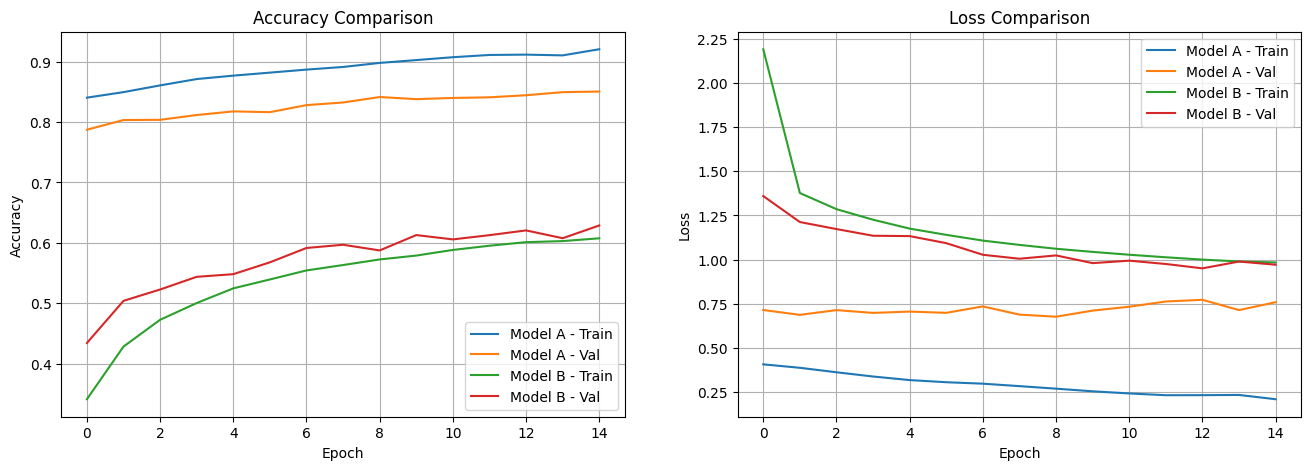

In [37]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5))

# Accuracy panel
ax1.plot(history_1.history['accuracy'], label='Model A - Train')
ax1.plot(history_1.history['val_accuracy'], label='Model A - Val')
ax1.plot(history.history['accuracy'], label='Model B - Train')
ax1.plot(history.history['val_accuracy'], label='Model B - Val')
ax1.set_title('Accuracy Comparison')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid()

# Loss panel
ax2.plot(history_1.history['loss'], label='Model A - Train')
ax2.plot(history_1.history['val_loss'], label='Model A - Val')
ax2.plot(history.history['loss'], label='Model B - Train')
ax2.plot(history.history['val_loss'], label='Model B - Val')
ax2.set_title('Loss Comparison')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid()

plt.show()